### Gathering Data

- Below we will gather all  the relevant data from different sources.

In [1]:
#Importing libraries
import pandas as pd
import tweepy
import numpy as np

In [2]:
# Gathering Master twitter archive file containing the dog rating etc.
twitter_archive= pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# twitter archive dataset.
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
#Finding NULLS in the data.
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
# Getting descriptive stats.
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [6]:
# Looking for any weird dog names.
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
Oliver         11
Penny          10
Lola           10
Tucker         10
Bo              9
Winston         9
the             8
Sadie           8
Daisy           7
Buddy           7
Bailey          7
Toby            7
an              7
Scout           6
Leo             6
Dave            6
Jax             6
Rusty           6
Stanley         6
Oscar           6
Bella           6
Jack            6
Koda            6
Milo            6
Chester         5
             ... 
Venti           1
Antony          1
Tilly           1
Carbon          1
Fletcher        1
Shawwn          1
Puff            1
this            1
Rupert          1
Rey             1
Tassy           1
Kenzie          1
Bayley          1
Griswold        1
Fillup          1
Kaia            1
Jebberson       1
Traviss         1
Brandonald      1
Cedrick         1
Mookie          1
old             1
Marty           1
Shiloh          1
Kaiya     

In [7]:
#finding duplicate tweet_ids if any.
twitter_archive[twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [8]:
# Looking at rating numerators.
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [9]:
# Looking at rating denominators.
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [10]:
# Gathering Image predictions file.
url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_pred= pd.read_table(url,sep='\t')

In [11]:
#Evaluating the dataset.
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
#Finding duplicates in the data.
image_pred[image_pred.duplicated()].any()

tweet_id    False
jpg_url     False
img_num     False
p1          False
p1_conf     False
p1_dog      False
p2          False
p2_conf     False
p2_dog      False
p3          False
p3_conf     False
p3_dog      False
dtype: bool

In [13]:
# Finding NULLS in the dataset.
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
#Looking for p1 predictions.
image_pred.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
Cardigan                      19
web_site                      19
Shetland_sheepdog             18
Eskimo_dog                    18
beagle                        18
teddy                         18
Maltese_dog                   18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

In [5]:
# Reating the data in to a dataframe from 'tweet-json.txt' file.
import pandas as pd
import json
df_tweets= pd.DataFrame(columns=['tweet_id','retweet_count','favorite_count'])
with open('tweet-json.txt') as file:
    for line in file:
        status= json.loads(line)
        tweet_id= status['id_str']
        rt_count= status['retweet_count']
        fav_count= status['favorite_count']
        df_tweets.append(pd.DataFrame([[tweet_id,rt_count,fav_count]],columns=['tweet_id','retweet_count','favorite_count']))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{"created_at": "Tue Dec 01 02:46:33 +0000 2015", "id": 671520732782923777, "id_str": "671520732782923777", "full_text": "Meet Alejandro. He's an extremely seductive pup. 10/10 https://t.co/C7dPcCUNpF", "truncated": false, "display_text_range": [0, 78], "entities": {"hashtags": [], "symbols": [], "user_mentions": [], "urls": [], "media": [{"id": 671520730169872384, "id_str": "671520730169872384", "indices": [55, 78], "media_url": "http://pbs.twimg.com/media/CVG4i9UWEAAUH3U.jpg", "media_url_https": "https://pbs.twimg.com/media/CVG4i9UWEAAUH3U.jpg", "url": "https://t.co/C7dPcCUNpF", "display_url": "pic.twitter.com/C7dPcCUNpF", "expanded_url": "https://twitter.com/dog_rates/status/671520732782923777/photo/1", "type": "photo", "sizes": {"small": {"w": 340, "h": 443, "resize": "fit"}, "thumb": {"w": 150, "h": 150, "resize": "crop"}, "medium": {"w": 500, "h": 651, "resize": "fit"}, "large": {"w": 500, "h": 651, "resize": "fit"}}}]}, "extended_entities": {"media": [{"id": 671520730169872384, "

In [16]:
df_tweets.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
0,892177421306343426,6514,33819
0,891815181378084864,4328,25461
0,891689557279858688,8964,42908
0,891327558926688256,9774,41048


In [17]:
#Finding common columns in all three data frames.
col_dup= pd.Series(list(twitter_archive)+list(image_pred)+list(df_tweets))
col_dup= col_dup[col_dup.duplicated()]
col_dup

17    tweet_id
29    tweet_id
dtype: object

# Asses

### Quality
#### Twitter Archive dataset.

- Rating numerator has 1776 entry. 
- Rating needs to be normalzied.
- Dog categories need to be changed to category rather than string.
- Erroneous data for name column where we see some names like 'a', 'just','actually' etc. Looks like names were not decoded right in the file from the tweets. Change them to 'NAN'.
- p1,p2 and p3 names should be in lower case totally.
- Few columns with NULLS in them. But not really important to clean them since those columns are not needed for analysis.
- timestamp column missing '_' compared to other column labeling.
- timestamp  needs to be changed to datetime type.
- Dog state column has multiple entries like 'doggo', 'puppo' etc. Need to be cleaned.

#### Image predictions dataset.


### Tidiness

- 'tweet_id' is a  common column in all 3 datasets. Should be part of the merged data frame.
- image prediction dataset should be part of the twitter archived dataset. Merging needed.



In [18]:
#Creating a clean copy.
twitter_archive_clean= twitter_archive.copy()
image_pred_clean= image_pred.copy()
df_tweets_clean= df_tweets.copy()

#### Define
** replacing non-dog names with nan.**

#### Code

In [19]:
mask= twitter_archive_clean.name.str.islower()
column_name= 'name'
twitter_archive_clean.loc[mask,column_name]= np.nan

#### Test

In [20]:
twitter_archive_clean.name.value_counts()

None          745
Charlie        12
Lucy           11
Cooper         11
Oliver         11
Lola           10
Penny          10
Tucker         10
Winston         9
Bo              9
Sadie           8
Buddy           7
Toby            7
Daisy           7
Bailey          7
Scout           6
Bella           6
Rusty           6
Jack            6
Oscar           6
Stanley         6
Dave            6
Jax             6
Milo            6
Leo             6
Koda            6
Sammy           5
Finn            5
George          5
Oakley          5
             ... 
Antony          1
Tilly           1
Carbon          1
Fletcher        1
Ester           1
Billl           1
Shawwn          1
Ridley          1
Traviss         1
Herb            1
Rey             1
Tassy           1
Kenzie          1
Bayley          1
Griswold        1
Fillup          1
Kaia            1
Jebberson       1
Rupert          1
Puff            1
Brandonald      1
Mookie          1
Marty           1
Shiloh          1
Kaiya     

#### Define 1.
** Dog category should be changed to category rather than strings.**

#### Code

In [21]:
twitter_archive_clean.doggo= twitter_archive_clean.doggo.astype('category')
twitter_archive_clean.floofer= twitter_archive_clean.floofer.astype('category')
twitter_archive_clean.pupper= twitter_archive_clean.pupper.astype('category')
twitter_archive_clean.puppo= twitter_archive_clean.puppo.astype('category')

#### Test

In [22]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2247 non-null object
doggo                         2356 non-null category
floofer                       2356 non-null category
pupper                        2356 non-null category
puppo                         2356 non-null category
dtypes: category(4), flo

#### Define 2.
** p1,p2 and p3 names should be changed to lower case.

#### Code

In [23]:
image_pred_clean.p1= image_pred_clean.p1.str.lower()
image_pred_clean.p2= image_pred_clean.p2.str.lower()
image_pred_clean.p3= image_pred_clean.p3.str.lower()

#### Test

In [24]:
image_pred_clean.p1.value_counts(),image_pred_clean.p2.value_counts(),image_pred_clean.p3.value_counts()

(golden_retriever             150
 labrador_retriever           100
 pembroke                      89
 chihuahua                     83
 pug                           57
 chow                          44
 samoyed                       43
 toy_poodle                    39
 pomeranian                    38
 cocker_spaniel                30
 malamute                      30
 french_bulldog                26
 chesapeake_bay_retriever      23
 miniature_pinscher            23
 seat_belt                     22
 siberian_husky                20
 staffordshire_bullterrier     20
 german_shepherd               20
 web_site                      19
 cardigan                      19
 beagle                        18
 shetland_sheepdog             18
 maltese_dog                   18
 teddy                         18
 eskimo_dog                    18
 rottweiler                    17
 lakeland_terrier              17
 shih-tzu                      17
 italian_greyhound             16
 kuvasz       

#### Define 3.
** timestamp column in twitter_archive needs to be changed to date time format. **

#### Code.

In [25]:
twitter_archive_clean.timestamp=pd.to_datetime(twitter_archive_clean.timestamp)

#### Test

In [26]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2247 non-null object
doggo                         2356 non-null category
floofer                       2356 non-null category
pupper                        2356 non-null category
puppo                         2356 non-null category
dtypes: category

#### Define4.
** change timestamp column name to time_stamp for consistency.

#### Code.

In [27]:
twitter_archive_clean.rename(columns={'timestamp':'time_stamp'},inplace=True)

#### Test

In [28]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,time_stamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Define 5.
** Change tweet_id column type to string instead of integer for easy merging at the end.

#### Code

In [29]:
twitter_archive_clean.tweet_id= twitter_archive_clean.tweet_id.astype('str')

#### Test

In [30]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
time_stamp                    2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2247 non-null object
doggo                         2356 non-null category
floofer                       2356 non-null category
pupper                        2356 non-null category
puppo                         2356 non-null category
dtypes: categor

#### Define
** Finding rows with multiple dog stages in it **

#### Code

In [31]:
twitter_archive_clean.doggo.replace('None', '', inplace=True)
twitter_archive_clean.floofer.replace('None', '', inplace=True)
twitter_archive_clean.pupper.replace('None', '', inplace=True)
twitter_archive_clean.puppo.replace('None', '', inplace=True)

In [32]:
# Then combine stage columns.

twitter_archive_clean['stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo

In [33]:
# Then format entries with multiple dog stages which appeared like doggo,pupper.

twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggopupper', 'stage'] = 'doggo,pupper'

twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggopuppo', 'stage'] = 'doggo,puppo'

twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'

#### Test

In [34]:
twitter_archive_clean.stage.value_counts()

                 1976
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,floofer       1
doggo,puppo         1
Name: stage, dtype: int64

#### Define
** Normalize rating values since rating numerators in some case are higher than denominator**

#### Code

In [35]:
twitter_archive_clean['rating_normalized']= twitter_archive_clean['rating_numerator']/twitter_archive_clean['rating_denominator']

#### Test

In [36]:
twitter_archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,time_stamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,rating_normalized
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,,,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,,,1.3


#### Define
** Removing 1776 value in rating_numerator as outlier.**

#### Code

In [37]:
twitter_archive_clean.drop(twitter_archive_clean[twitter_archive_clean['rating_numerator'] == 1776].index, inplace = True)

#### Test

In [38]:
twitter_archive_clean.query('rating_numerator==1776')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,time_stamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,rating_normalized


### Tidiness

In [39]:
#### Define
**Both tidiness issues can be solved below.
1. tweet_id which is a common column.
2. Merging all three datasets by tweet_id**

SyntaxError: invalid syntax (<ipython-input-39-dec0a9c6974e>, line 2)

#### Code

In [40]:
image_pred_clean.tweet_id= image_pred_clean.tweet_id.astype('str')

#### Test

In [41]:
twitter_archive_master= twitter_archive_clean.merge(image_pred_clean,on='tweet_id').merge(df_tweets_clean,on='tweet_id')

In [42]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 32 columns):
tweet_id                      2072 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
time_stamp                    2072 non-null datetime64[ns]
source                        2072 non-null object
text                          2072 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null int64
rating_denominator            2072 non-null int64
name                          1972 non-null object
doggo                         2072 non-null object
floofer                       2072 non-null object
pupper                        2072 non-null object
puppo                         2072 non-null object
stage                     

In [43]:
twitter_archive_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,time_stamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,6514,33819
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,9774,41048


In [53]:
twitter_archive_master.to_csv('twitter_archive_master.csv')

### Insights and Visualization.

In [70]:
#Finding the dog stage proportions
dogstage_prop=twitter_archive_master['stage'].value_counts()
dogstage_prop

                 1752
pupper            210
doggo              67
puppo              23
doggo,pupper       11
floofer             7
doggo,floofer       1
doggo,puppo         1
Name: stage, dtype: int64

 ** It looks like pupper is the most tweeted dog stage category. **

In [68]:
# Finding favorite dog breed.
twitter_archive_master.favorite_count= twitter_archive_master.favorite_count.astype('int')
fav_dog= twitter_archive_master.query('p1_dog==True').groupby(['p1'])['favorite_count'].mean()
fav_dog.sort_values(ascending=False)

p1
saluki                         24060.000000
french_bulldog                 17913.000000
black-and-tan_coonhound        17012.000000
flat-coated_retriever          16791.625000
irish_water_spaniel            16400.000000
leonberg                       14934.333333
english_springer               14091.500000
basset                         13866.000000
standard_poodle                13812.750000
cardigan                       13699.315789
border_terrier                 13578.000000
bedlington_terrier             13025.000000
afghan_hound                   12995.000000
great_pyrenees                 12932.000000
mexican_hairless               12640.500000
samoyed                        12627.697674
giant_schnauzer                12442.000000
lakeland_terrier               12193.647059
eskimo_dog                     12001.555556
weimaraner                     11982.750000
golden_retriever               11310.846667
pembroke                       11304.034091
labrador_retriever           

In [ ]:
** On an average scale of favorite_count, Saluki is the most favorite dog averaging 24060.**

In [121]:
#Which dog breed has the best ratings.
dog_rating= twitter_archive_master.query('p1_dog==True').groupby(['p1'])['rating_normalized'].mean()
dog_rating.sort_values(ascending=False)

p1
clumber                        2.700000
pomeranian                     1.286842
saluki                         1.250000
tibetan_mastiff                1.240000
briard                         1.233333
border_terrier                 1.214286
kuvasz                         1.206250
silky_terrier                  1.200000
standard_schnauzer             1.200000
giant_schnauzer                1.200000
irish_setter                   1.183333
eskimo_dog                     1.177778
gordon_setter                  1.175000
samoyed                        1.169767
golden_retriever               1.169645
chow                           1.163636
cardigan                       1.152632
great_pyrenees                 1.150000
wire-haired_fox_terrier        1.150000
australian_terrier             1.150000
kelpie                         1.145455
pembroke                       1.144318
norfolk_terrier                1.142857
cocker_spaniel                 1.140000
greater_swiss_mountain_dog     1.1333

In [ ]:
** Clumber has the best normalized rating. It received 27/10 scale.**

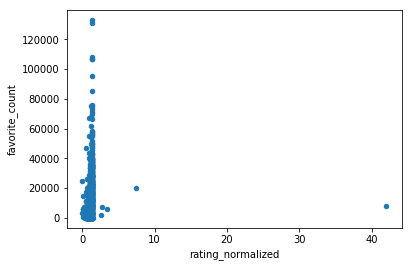

In [105]:
#Finding correlation between p1_conf vs favorite_count if any.
twitter_archive_master.plot(x='rating_normalized',y='favorite_count',kind='scatter')


In [ ]:
** No linear relation exists between p1_conf and favorite_count.**

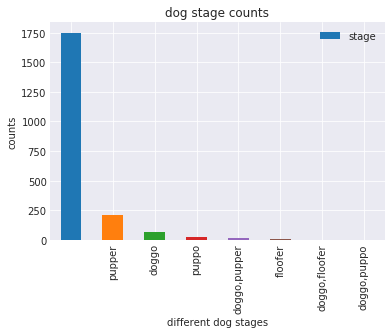

In [117]:
import seaborn as sns
sns.set_style('darkgrid')
twitter_archive_master.stage.value_counts().plot(kind='bar',title='dog stage counts');
plt.xlabel('different dog stages')
plt.ylabel('counts');
plt.legend();

In [ ]:
** Pupper was reported the most in the tweets.**